### This notebook is to perform random forest classification on 24,25-(OH)2D

In [1]:
import numpy as np
import pandas as pd
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier

In [2]:
taxa = pd.read_csv('../Qiime_updated/taxonomy.tsv', sep='\t', index_col='Feature ID')

In [3]:
taxa.head()

Taxon
Feature ID                                                                                           
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCAC...  k__Bacteria; p__Proteobacteria; c__Gammaproteo...
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...
AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGC...  k__Bacteria; p__Firmicutes; c__Clostridia; o__...

In [4]:
mf = pd.read_csv('../data/mros_mapping_alpha.txt', sep='\t', index_col='#SampleID')

In [5]:
mf.head()

BarcodeSequence  LinkerPrimerSequence  \
#SampleID                                         
BI0023       TCTGGTGACATT  GGACTACHVGGGTWTCTAAT   
BI0056       CAAGCATGCCTA  GGACTACHVGGGTWTCTAAT   
BI0131       CTATTTGCGACA  GGACTACHVGGGTWTCTAAT   
BI0153       ATCGGCGTTACA  GGACTACHVGGGTWTCTAAT   
BI0215       CCTCTCGTGATC  GGACTACHVGGGTWTCTAAT   

                               Experiment_Design_Description  \
#SampleID                                                      
BI0023     16S stool samples sequenced for MrOS Vitamin D...   
BI0056     16S stool samples sequenced for MrOS Vitamin D...   
BI0131     16S stool samples sequenced for MrOS Vitamin D...   
BI0153     16S stool samples sequenced for MrOS Vitamin D...   
BI0215     16S stool samples sequenced for MrOS Vitamin D...   

          Library_Construction_Protocol Linker  Platform Center_Name  \
#SampleID                                                              
BI0023                      16S rRNA v4     GT  Illumina          BI   
BI0056                      16S rRNA v4     GT  Illumina          BI   
BI0131                      16S rRNA v4     GT  Illumina          BI   
BI0153                      16S rRNA v4     GT  Illumina          BI   
BI0215                      16S rRNA v4     GT  Illumina          BI   

          Center_Project Instrument_Model          Title    ...    M1STATIN  \
#SampleID                                                   ...               
BI0023              MrOS   Illumina MiSeq  MrOS_VitaminD    ...       0: No   
BI0056              MrOS   Illumina MiSeq  MrOS_VitaminD    ...       0: No   
BI0131              MrOS   Illumina MiSeq  MrOS_VitaminD    ...      1: Yes   
BI0153              MrOS   Illumina MiSeq  MrOS_VitaminD    ...      1: Yes   
BI0215              MrOS   Illumina MiSeq  MrOS_VitaminD    ...       0: No   

          Antihistamine Laxative  MIDATA Rstarch_total Rstarches_c   alpha_pd  \
#SampleID                                                                       
BI0023             0:No     0:No  1: Yes      3.066569         0.0  27.771167   
BI0056             0:No     0:No  1: Yes      3.038136         0.0  17.932659   
BI0131             0:No     0:No  1: Yes      2.840599         0.0  21.453663   
BI0153             0:No     0:No  1: Yes      4.106798         0.0  18.469675   
BI0215             0:No     0:No  1: Yes      0.971114         0.0  20.049827   

          observed_otus   shannon  pielou_e  
#SampleID                                    
BI0023              302  5.727116  0.695173  
BI0056              173  3.888281  0.522996  
BI0131              223  4.050730  0.519264  
BI0153              223  4.894253  0.627396  
BI0215              222  5.295055  0.679340  

[5 rows x 77 columns]

In [6]:
# create extreme categories on Vitamin D measurements
mf = mf[['OHV1D3', 'OHV24D3', 'OHVD3', 'ratio_activation', 'ratio_catabolism', 'VDstatus']]
mf.shape

(599, 6)

In [7]:
mf.describe()

OHV1D3     OHV24D3       OHVD3  ratio_activation  ratio_catabolism
count  567.000000  567.000000  556.000000        556.000000        556.000000
mean     0.057775    3.430864   35.229137          0.001772          0.094776
std      0.019773    1.834771   12.450758          0.000735          0.029770
min      0.010700    0.300000    7.800000          0.000398          0.018788
25%      0.044100    2.175000   27.400000          0.001316          0.074216
50%      0.055500    3.180000   33.650000          0.001660          0.092821
75%      0.066300    4.235000   41.825000          0.002081          0.112849
max      0.156000   14.070000  104.000000          0.006727          0.197786

/Users/ssun/miniconda3/envs/analysis/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


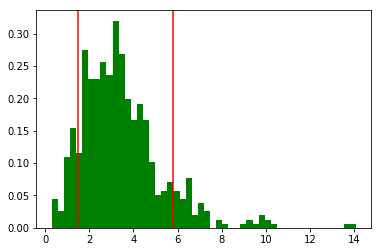

In [9]:
n, bins, patches = plt.hist(mf.OHV24D3.dropna(), 50, normed=1, facecolor='green')
plt.axvline(x=mf['OHV24D3'].quantile([0.10]).values, color='r')
plt.axvline(x=mf['OHV24D3'].quantile([0.90]).values, color='r')

In [10]:
q1 = mf['OHV24D3'].quantile([0.10]).values
q3 = mf['OHV24D3'].quantile([0.90]).values
def V24D3_extreme(x):
    if (x <= q1):
        return(0)
    elif (x >= q3):
        return(1)
    else:
        return('NaN')
mf['V24D3_cat'] = mf['OHV24D3'].apply(V24D3_extreme)

In [11]:
mf['V24D3_cat'].value_counts()

NaN    484
1       58
0       57
Name: V24D3_cat, dtype: int64

In [12]:
table = pd.read_csv('../Qiime_updated/feature-table-rare5807.txt', sep='\t', skiprows = 1, index_col = "#OTU ID").transpose()

In [13]:
table.head()

#OTU ID  TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAAC  \
MN1696                                              2011.0                                                                                                                                                                                                            
PI4923                                                 0.0                                                                                                                                                                                                            
PA3754                                                32.0                                                                                                                                                                                                            
PI4717                                                37.0                                                                                                                                                                                                            
PA3960                                                 0.0                                                                                                                                                                                                            

#OTU ID  TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAAC  \
MN1696                                               520.0                                                                                                                                                                                                            
PI4923                                               250.0                                                                                                                                                                                                            
PA3754                                                 0.0                                                                                                                                                                                                            
PI4717                                                 5.0                                                                                                                                                                                                            
PA3960                                                 0.0                                                                                                                                                                                                            

#OTU ID  TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGATTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGAAACTGGCAGTCTTGAGTACAGTAGAGGTGGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTCACTAGACTGCAACTGACACTGATGCTCGAAAGTGTGGGTATCAAAC  \
MN1696                                               457.0                                                                                                                                                                                                            
PI4923                                                66.0                                                                                                                                                                                                            
PA3754                                               

In [14]:
table.shape

(599, 39885)

In [15]:
## match metadata and OTU table by sampleID
sample_ids = mf.index
sample_ids

Index(['BI0023', 'BI0056', 'BI0131', 'BI0153', 'BI0215', 'BI0353', 'BI0371',
       'BI0372', 'BI0380', 'BI0389',
       ...
       'SD8964', 'SD8966', 'SD8972', 'SD8973', 'SD8985', 'SD8996', 'SD8999',
       'SD9001', 'SD9003', 'SD9009'],
      dtype='object', name='#SampleID', length=599)

In [16]:
table = table.loc[sample_ids] # order rows in same order as matrix's rows (sampleIDs)

In [17]:
table.head()

#OTU ID    TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAAC  \
#SampleID                                                                                                                                                                                                                                                               
BI0023                                                   0.0                                                                                                                                                                                                            
BI0056                                                   0.0                                                                                                                                                                                                            
BI0131                                                 133.0                                                                                                                                                                                                            
BI0153                                                 225.0                                                                                                                                                                                                            
BI0215                                                 153.0                                                                                                                                                                                                            

#OTU ID    TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAAC  \
#SampleID                                                                                                                                                                                                                                                               
BI0023                                                   6.0                                                                                                                                                                                                            
BI0056                                                   0.0                                                                                                                                                                                                            
BI0131                                                2574.0                                                                                                                                                                                                            
BI0153                                                  19.0                                                                                                                                                                                                            
BI0215                                                   1.0                                                                                                                                                                                                            

#OTU ID    TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGATTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGAAACTGGCAGTCTTGAGTACAGTAGAGGTGGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTCACTAGACTGCAACTGACACTGATGCTCGAAAGTGTGGGTATCAAAC  \
#SampleID              

## random forest classification 

### 24, 25

In [18]:
# filter away samples with NaN values
Y = mf[mf.V24D3_cat != 'NaN']
Y.shape

(115, 7)

In [19]:
X = table.loc[Y.index]
X.shape

(115, 39885)

In [20]:
# convert to numpy array
# X - rarefied OTU table; Y - vitamin D categories
y = pd.factorize(Y['V24D3_cat'])[0] # to get dtype 'int' instead of 'O'
X = X.as_matrix()

In [21]:
m = np.logspace(2, 8, num=9, base=2, dtype=int)
param_grid = {"max_features": m,
              "min_samples_split": [2, 3, 7],
              "min_samples_leaf": [1, 3, 7],
              "bootstrap": [True, False]}
ParameterGrid(param_grid)[1]

{'bootstrap': True,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}


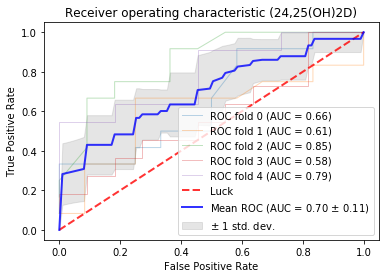

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 3, 'min_samples_leaf': 1}


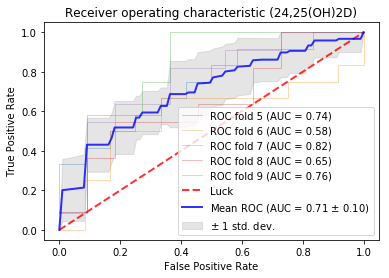

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 7, 'min_samples_leaf': 1}


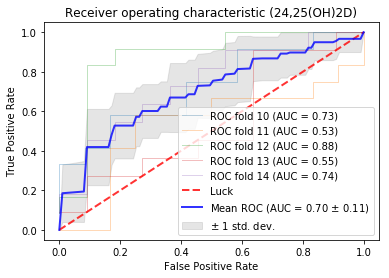

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}


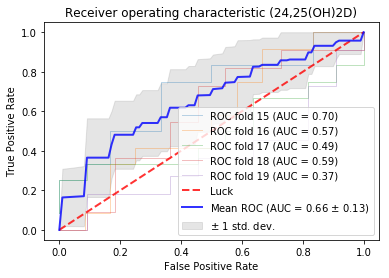

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 3, 'min_samples_leaf': 3}


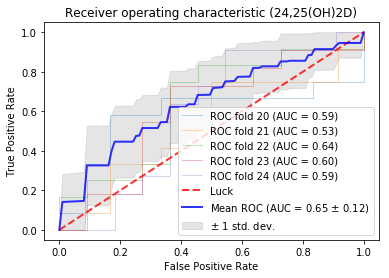

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 7, 'min_samples_leaf': 3}


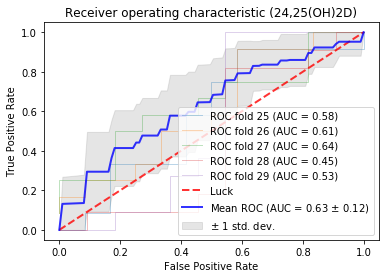

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 2, 'min_samples_leaf': 7}


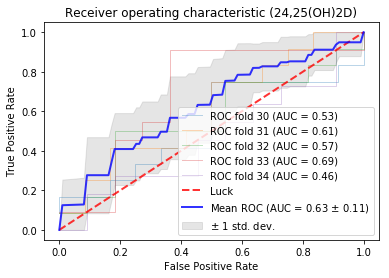

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}


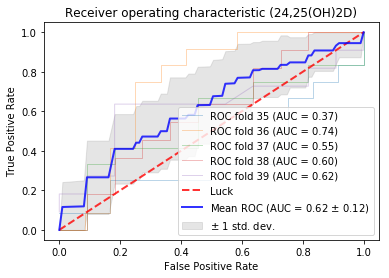

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 7, 'min_samples_leaf': 7}


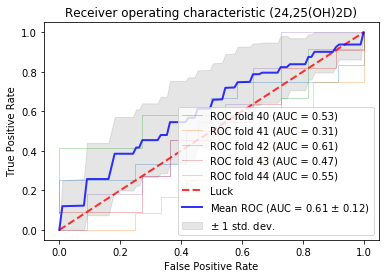

{'bootstrap': True, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}


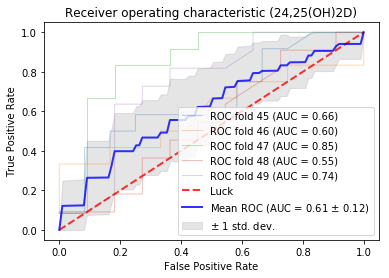

{'bootstrap': True, 'max_features': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}


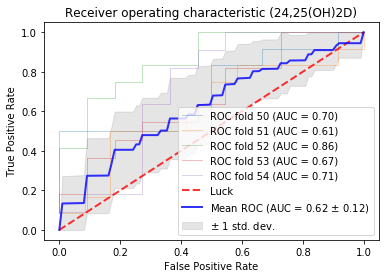

{'bootstrap': True, 'max_features': 6, 'min_samples_split': 7, 'min_samples_leaf': 1}


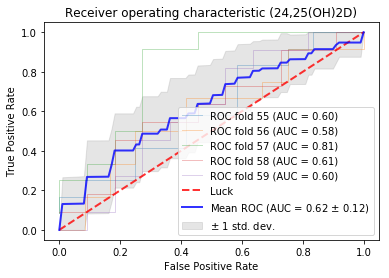

{'bootstrap': True, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}


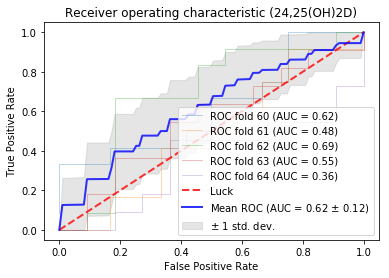

{'bootstrap': True, 'max_features': 6, 'min_samples_split': 3, 'min_samples_leaf': 3}


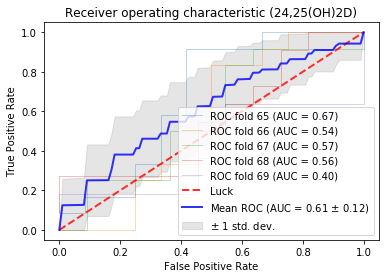

{'bootstrap': True, 'max_features': 6, 'min_samples_split': 7, 'min_samples_leaf': 3}


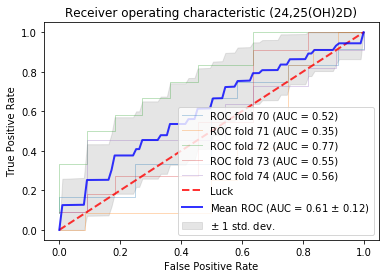

{'bootstrap': True, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}


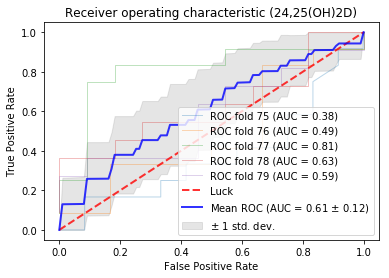

{'bootstrap': True, 'max_features': 6, 'min_samples_split': 3, 'min_samples_leaf': 7}


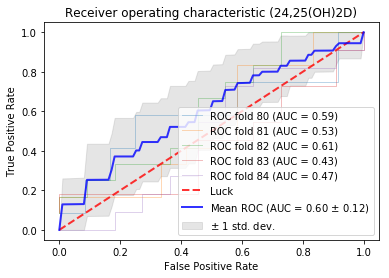

{'bootstrap': True, 'max_features': 6, 'min_samples_split': 7, 'min_samples_leaf': 7}


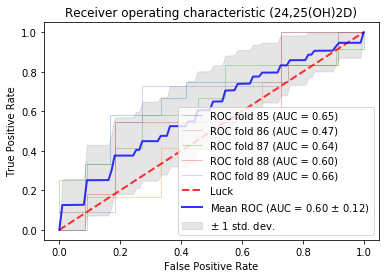

{'bootstrap': True, 'max_features': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}


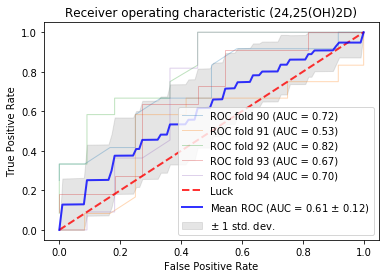

{'bootstrap': True, 'max_features': 11, 'min_samples_split': 3, 'min_samples_leaf': 1}


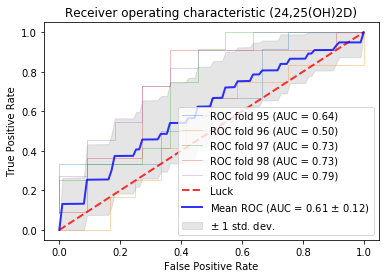

{'bootstrap': True, 'max_features': 11, 'min_samples_split': 7, 'min_samples_leaf': 1}


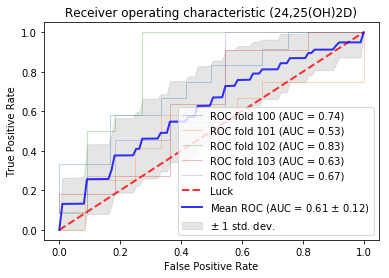

{'bootstrap': True, 'max_features': 11, 'min_samples_split': 2, 'min_samples_leaf': 3}


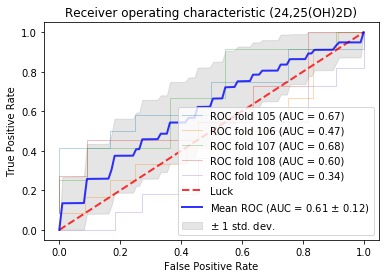

{'bootstrap': True, 'max_features': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}


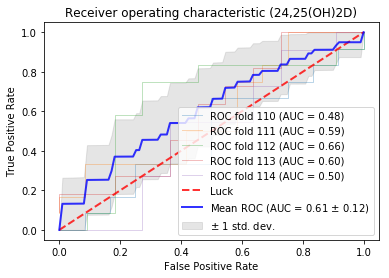

{'bootstrap': True, 'max_features': 11, 'min_samples_split': 7, 'min_samples_leaf': 3}


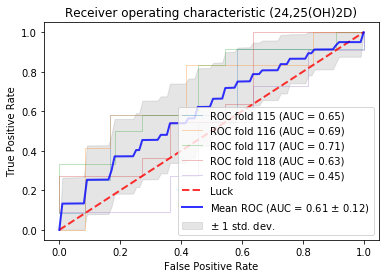

{'bootstrap': True, 'max_features': 11, 'min_samples_split': 2, 'min_samples_leaf': 7}


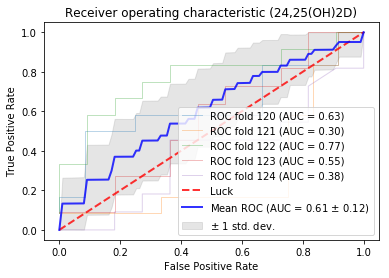

{'bootstrap': True, 'max_features': 11, 'min_samples_split': 3, 'min_samples_leaf': 7}


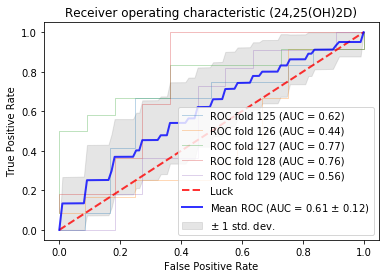

{'bootstrap': True, 'max_features': 11, 'min_samples_split': 7, 'min_samples_leaf': 7}


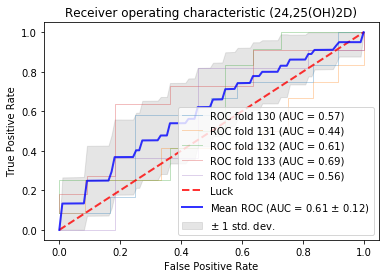

{'bootstrap': True, 'max_features': 19, 'min_samples_split': 2, 'min_samples_leaf': 1}


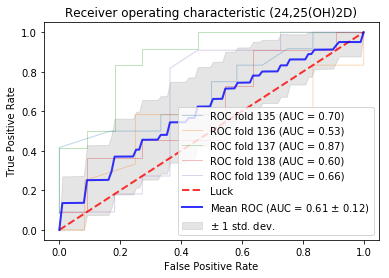

{'bootstrap': True, 'max_features': 19, 'min_samples_split': 3, 'min_samples_leaf': 1}


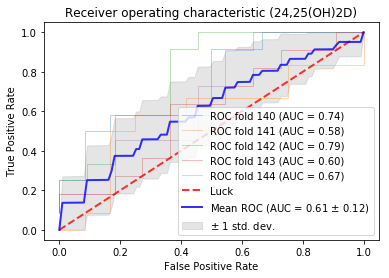

{'bootstrap': True, 'max_features': 19, 'min_samples_split': 7, 'min_samples_leaf': 1}


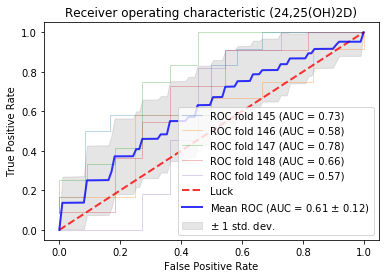

{'bootstrap': True, 'max_features': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}


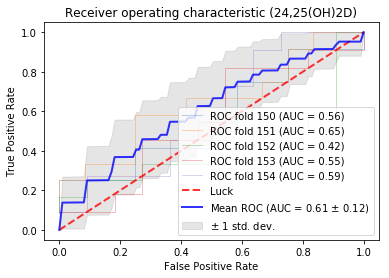

{'bootstrap': True, 'max_features': 19, 'min_samples_split': 3, 'min_samples_leaf': 3}


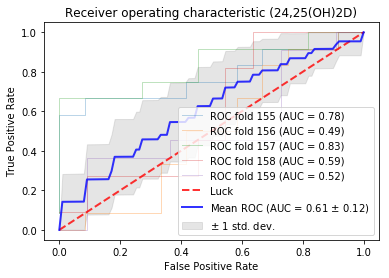

{'bootstrap': True, 'max_features': 19, 'min_samples_split': 7, 'min_samples_leaf': 3}


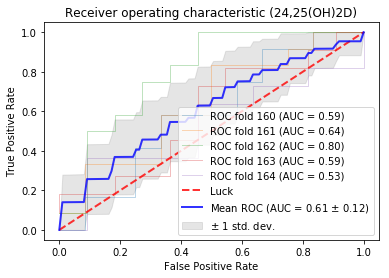

{'bootstrap': True, 'max_features': 19, 'min_samples_split': 2, 'min_samples_leaf': 7}


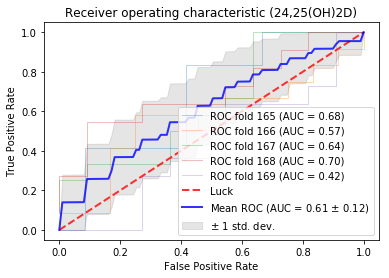

{'bootstrap': True, 'max_features': 19, 'min_samples_split': 3, 'min_samples_leaf': 7}


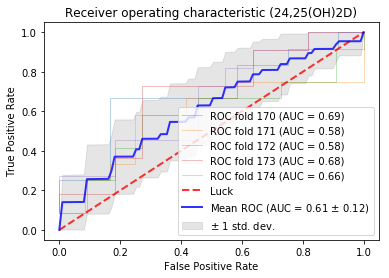

{'bootstrap': True, 'max_features': 19, 'min_samples_split': 7, 'min_samples_leaf': 7}


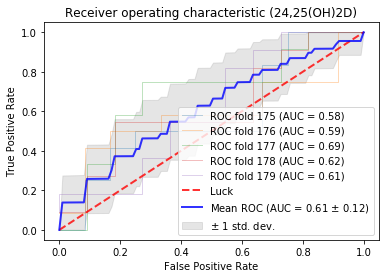

{'bootstrap': True, 'max_features': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}


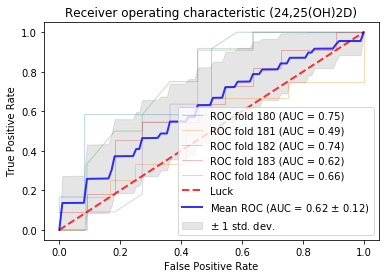

{'bootstrap': True, 'max_features': 32, 'min_samples_split': 3, 'min_samples_leaf': 1}


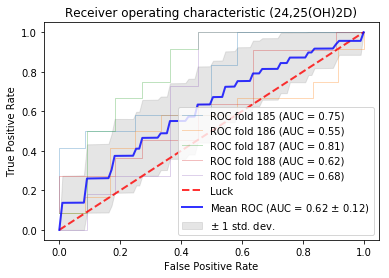

{'bootstrap': True, 'max_features': 32, 'min_samples_split': 7, 'min_samples_leaf': 1}


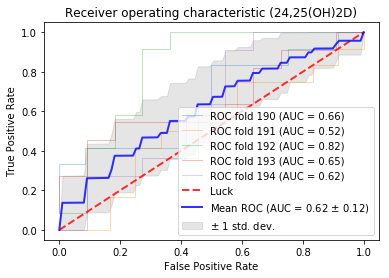

{'bootstrap': True, 'max_features': 32, 'min_samples_split': 2, 'min_samples_leaf': 3}


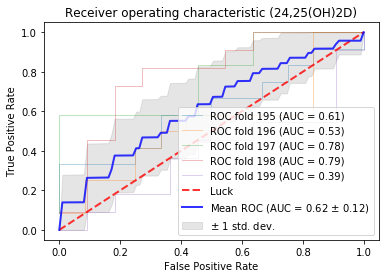

{'bootstrap': True, 'max_features': 32, 'min_samples_split': 3, 'min_samples_leaf': 3}


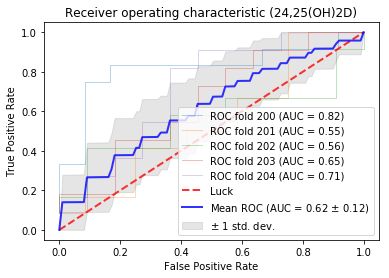

{'bootstrap': True, 'max_features': 32, 'min_samples_split': 7, 'min_samples_leaf': 3}


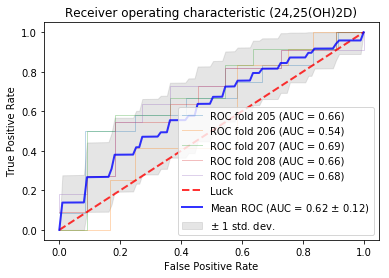

{'bootstrap': True, 'max_features': 32, 'min_samples_split': 2, 'min_samples_leaf': 7}


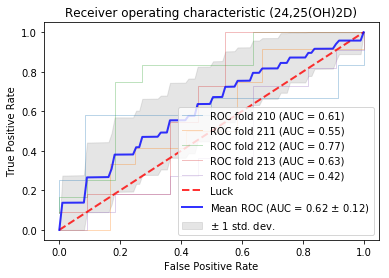

{'bootstrap': True, 'max_features': 32, 'min_samples_split': 3, 'min_samples_leaf': 7}


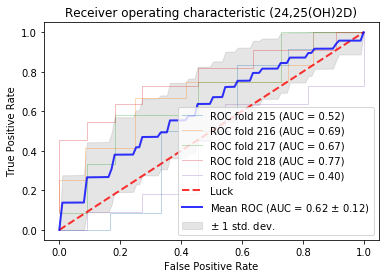

{'bootstrap': True, 'max_features': 32, 'min_samples_split': 7, 'min_samples_leaf': 7}


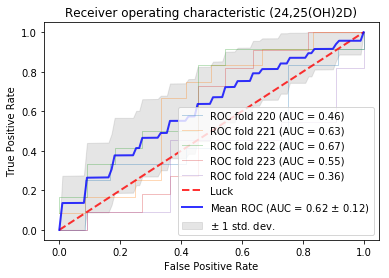

{'bootstrap': True, 'max_features': 53, 'min_samples_split': 2, 'min_samples_leaf': 1}


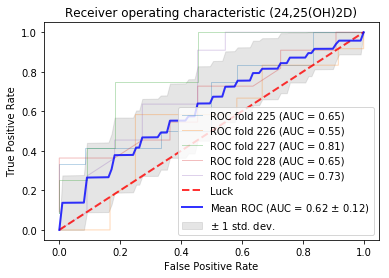

{'bootstrap': True, 'max_features': 53, 'min_samples_split': 3, 'min_samples_leaf': 1}


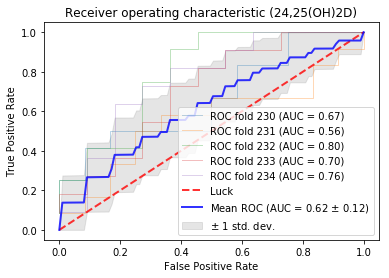

{'bootstrap': True, 'max_features': 53, 'min_samples_split': 7, 'min_samples_leaf': 1}


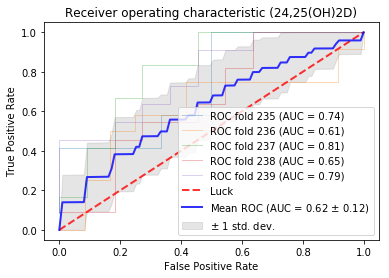

{'bootstrap': True, 'max_features': 53, 'min_samples_split': 2, 'min_samples_leaf': 3}


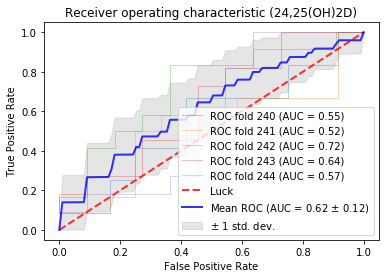

{'bootstrap': True, 'max_features': 53, 'min_samples_split': 3, 'min_samples_leaf': 3}


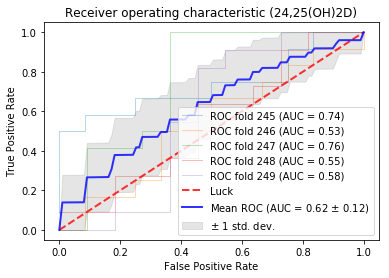

{'bootstrap': True, 'max_features': 53, 'min_samples_split': 7, 'min_samples_leaf': 3}


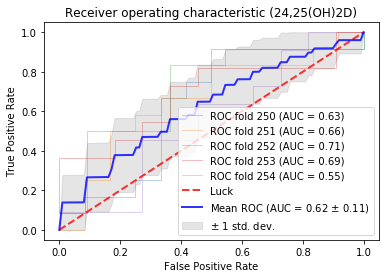

{'bootstrap': True, 'max_features': 53, 'min_samples_split': 2, 'min_samples_leaf': 7}


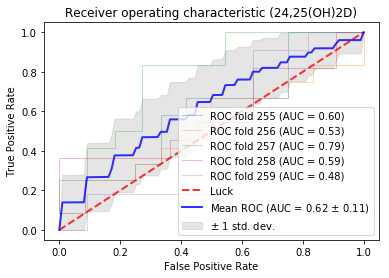

{'bootstrap': True, 'max_features': 53, 'min_samples_split': 3, 'min_samples_leaf': 7}


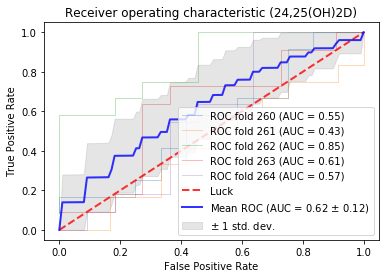

{'bootstrap': True, 'max_features': 53, 'min_samples_split': 7, 'min_samples_leaf': 7}


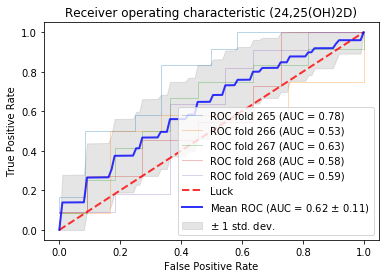

{'bootstrap': True, 'max_features': 90, 'min_samples_split': 2, 'min_samples_leaf': 1}


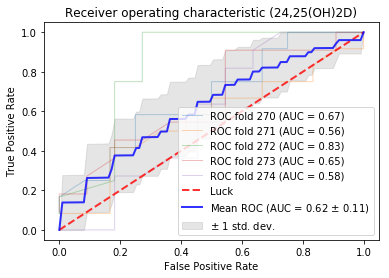

{'bootstrap': True, 'max_features': 90, 'min_samples_split': 3, 'min_samples_leaf': 1}


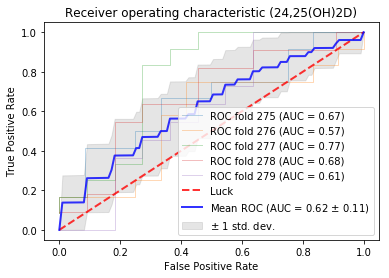

{'bootstrap': True, 'max_features': 90, 'min_samples_split': 7, 'min_samples_leaf': 1}


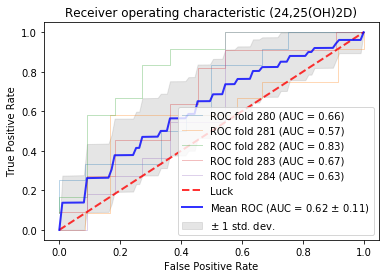

{'bootstrap': True, 'max_features': 90, 'min_samples_split': 2, 'min_samples_leaf': 3}


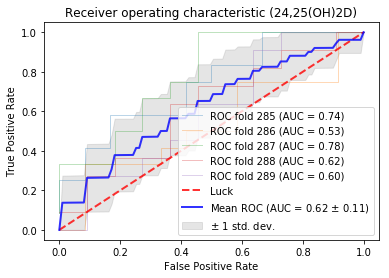

{'bootstrap': True, 'max_features': 90, 'min_samples_split': 3, 'min_samples_leaf': 3}


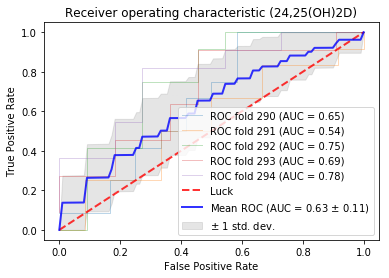

{'bootstrap': True, 'max_features': 90, 'min_samples_split': 7, 'min_samples_leaf': 3}


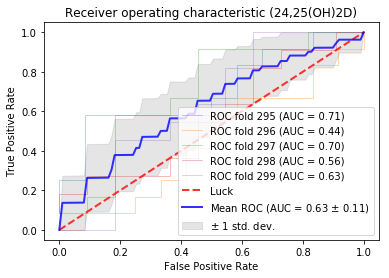

{'bootstrap': True, 'max_features': 90, 'min_samples_split': 2, 'min_samples_leaf': 7}


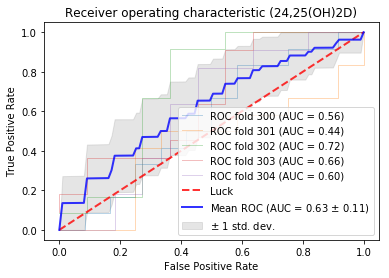

{'bootstrap': True, 'max_features': 90, 'min_samples_split': 3, 'min_samples_leaf': 7}


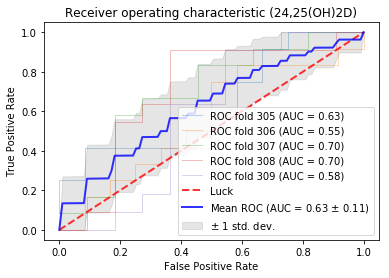

{'bootstrap': True, 'max_features': 90, 'min_samples_split': 7, 'min_samples_leaf': 7}


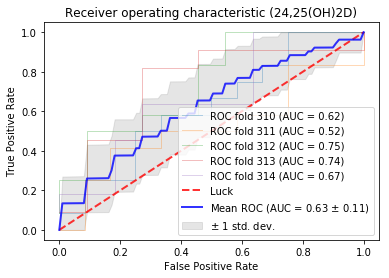

{'bootstrap': True, 'max_features': 152, 'min_samples_split': 2, 'min_samples_leaf': 1}


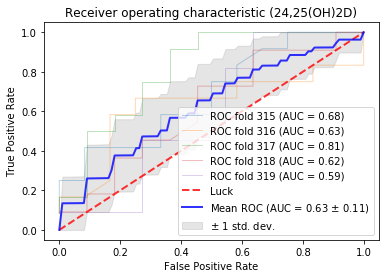

{'bootstrap': True, 'max_features': 152, 'min_samples_split': 3, 'min_samples_leaf': 1}


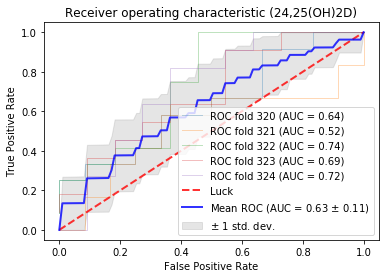

{'bootstrap': True, 'max_features': 152, 'min_samples_split': 7, 'min_samples_leaf': 1}


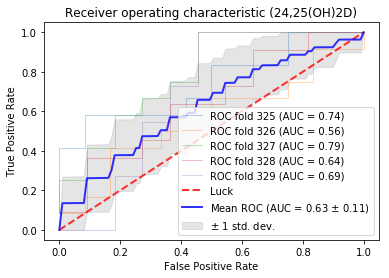

{'bootstrap': True, 'max_features': 152, 'min_samples_split': 2, 'min_samples_leaf': 3}


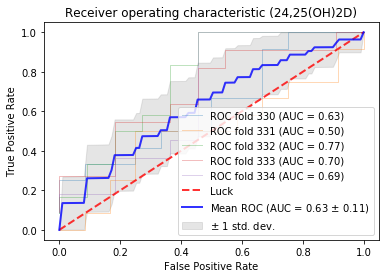

{'bootstrap': True, 'max_features': 152, 'min_samples_split': 3, 'min_samples_leaf': 3}


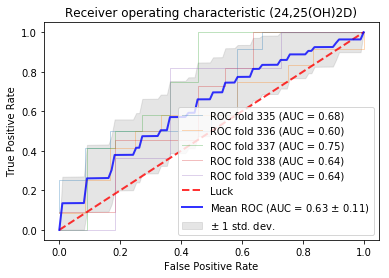

{'bootstrap': True, 'max_features': 152, 'min_samples_split': 7, 'min_samples_leaf': 3}


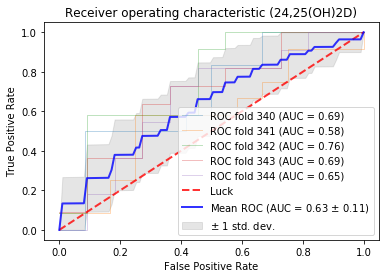

{'bootstrap': True, 'max_features': 152, 'min_samples_split': 2, 'min_samples_leaf': 7}


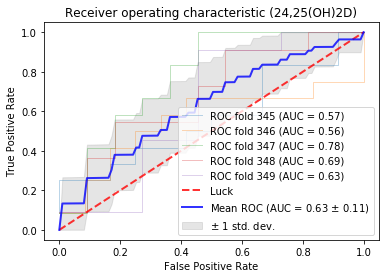

{'bootstrap': True, 'max_features': 152, 'min_samples_split': 3, 'min_samples_leaf': 7}


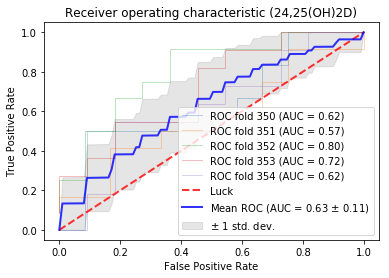

{'bootstrap': True, 'max_features': 152, 'min_samples_split': 7, 'min_samples_leaf': 7}


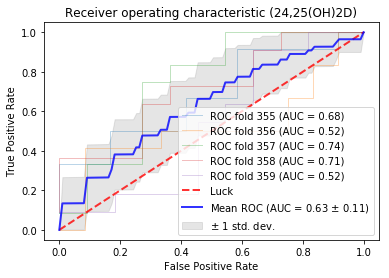

{'bootstrap': True, 'max_features': 256, 'min_samples_split': 2, 'min_samples_leaf': 1}


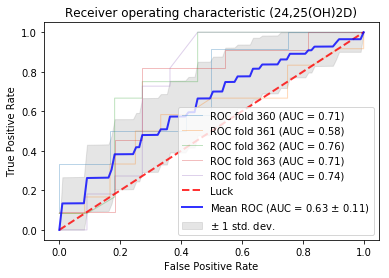

{'bootstrap': True, 'max_features': 256, 'min_samples_split': 3, 'min_samples_leaf': 1}


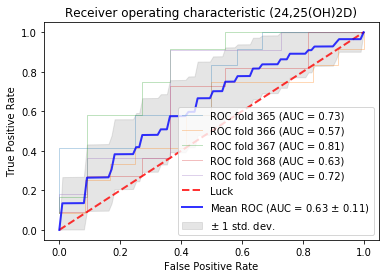

{'bootstrap': True, 'max_features': 256, 'min_samples_split': 7, 'min_samples_leaf': 1}


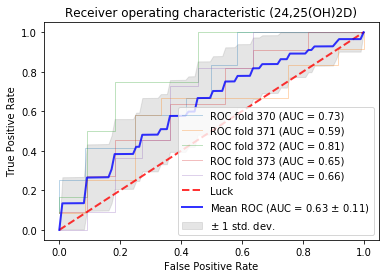

{'bootstrap': True, 'max_features': 256, 'min_samples_split': 2, 'min_samples_leaf': 3}


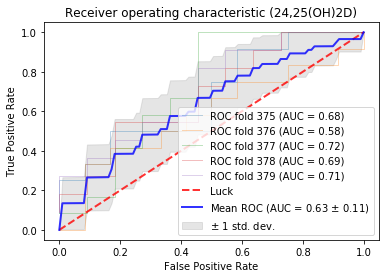

{'bootstrap': True, 'max_features': 256, 'min_samples_split': 3, 'min_samples_leaf': 3}


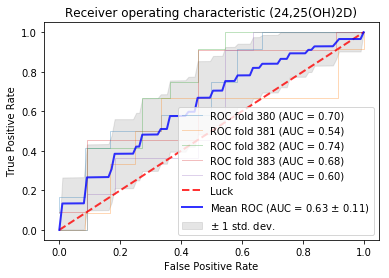

{'bootstrap': True, 'max_features': 256, 'min_samples_split': 7, 'min_samples_leaf': 3}


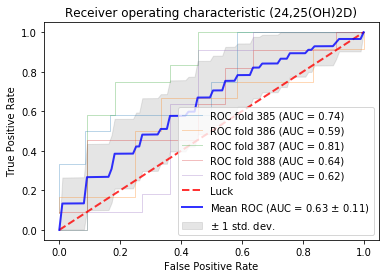

{'bootstrap': True, 'max_features': 256, 'min_samples_split': 2, 'min_samples_leaf': 7}


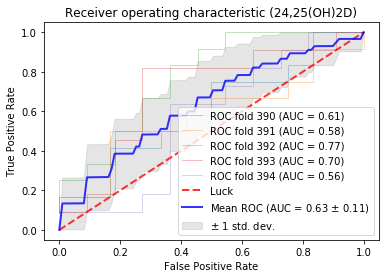

{'bootstrap': True, 'max_features': 256, 'min_samples_split': 3, 'min_samples_leaf': 7}


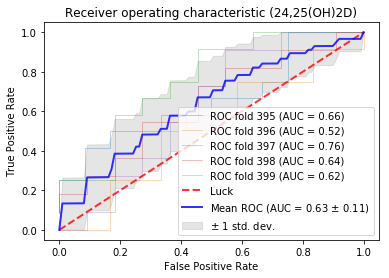

{'bootstrap': True, 'max_features': 256, 'min_samples_split': 7, 'min_samples_leaf': 7}


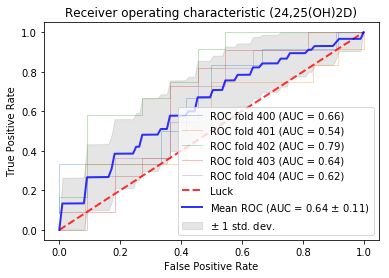

{'bootstrap': False, 'max_features': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}


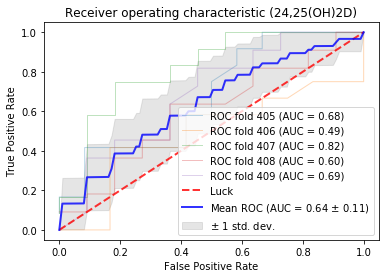

{'bootstrap': False, 'max_features': 4, 'min_samples_split': 3, 'min_samples_leaf': 1}


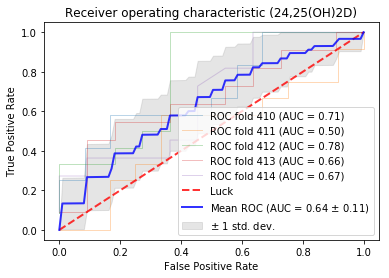

{'bootstrap': False, 'max_features': 4, 'min_samples_split': 7, 'min_samples_leaf': 1}


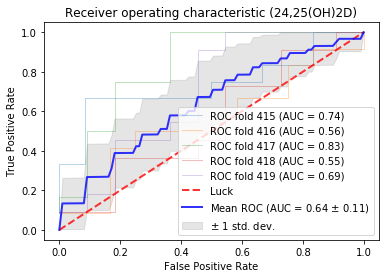

{'bootstrap': False, 'max_features': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}


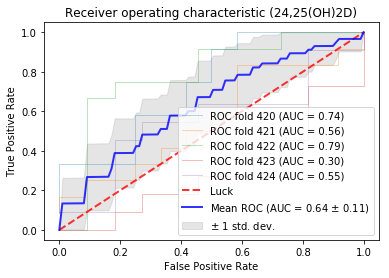

{'bootstrap': False, 'max_features': 4, 'min_samples_split': 3, 'min_samples_leaf': 3}


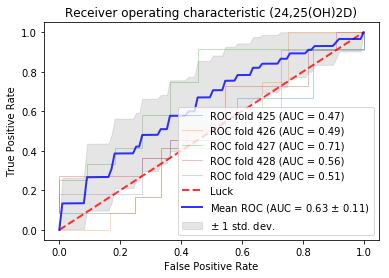

{'bootstrap': False, 'max_features': 4, 'min_samples_split': 7, 'min_samples_leaf': 3}


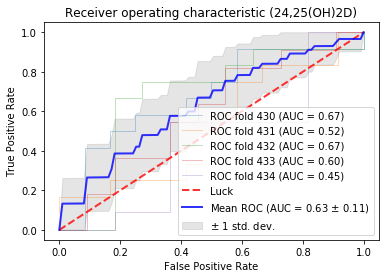

{'bootstrap': False, 'max_features': 4, 'min_samples_split': 2, 'min_samples_leaf': 7}


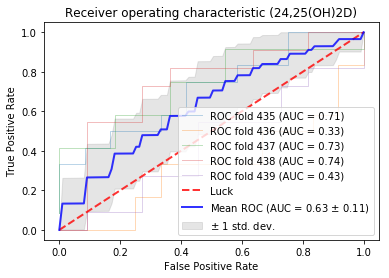

{'bootstrap': False, 'max_features': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}


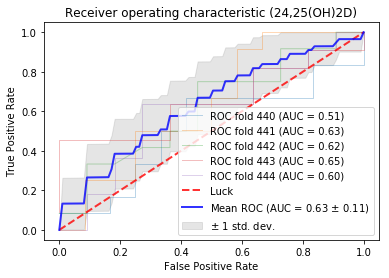

{'bootstrap': False, 'max_features': 4, 'min_samples_split': 7, 'min_samples_leaf': 7}


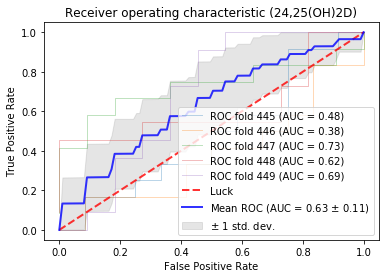

{'bootstrap': False, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}


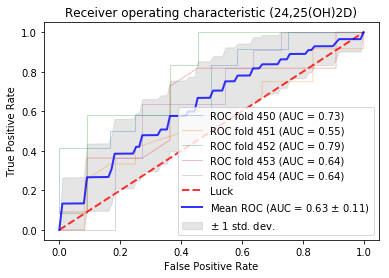

{'bootstrap': False, 'max_features': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}


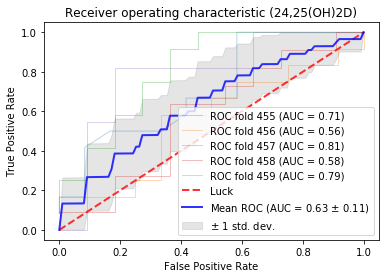

{'bootstrap': False, 'max_features': 6, 'min_samples_split': 7, 'min_samples_leaf': 1}


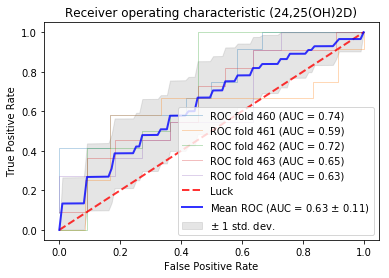

{'bootstrap': False, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}


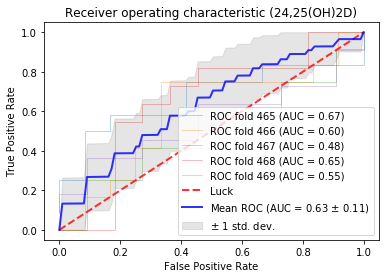

{'bootstrap': False, 'max_features': 6, 'min_samples_split': 3, 'min_samples_leaf': 3}


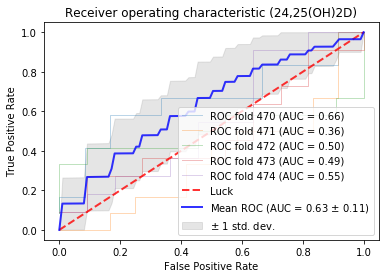

{'bootstrap': False, 'max_features': 6, 'min_samples_split': 7, 'min_samples_leaf': 3}


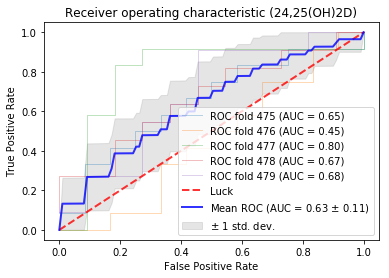

{'bootstrap': False, 'max_features': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}


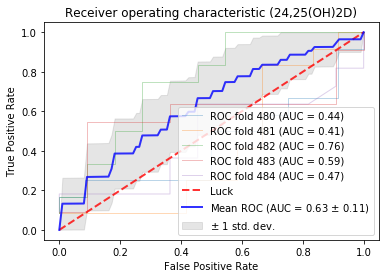

{'bootstrap': False, 'max_features': 6, 'min_samples_split': 3, 'min_samples_leaf': 7}


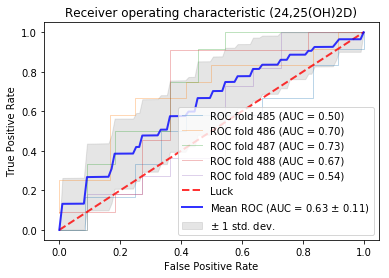

{'bootstrap': False, 'max_features': 6, 'min_samples_split': 7, 'min_samples_leaf': 7}


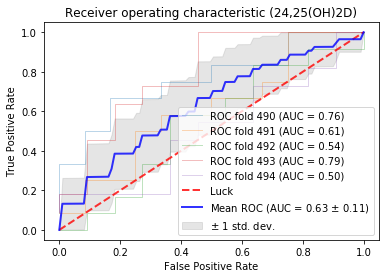

{'bootstrap': False, 'max_features': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}


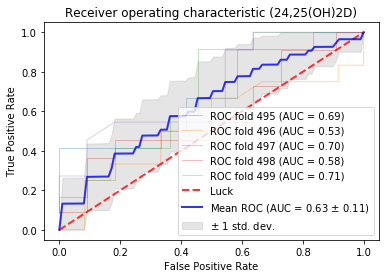

{'bootstrap': False, 'max_features': 11, 'min_samples_split': 3, 'min_samples_leaf': 1}


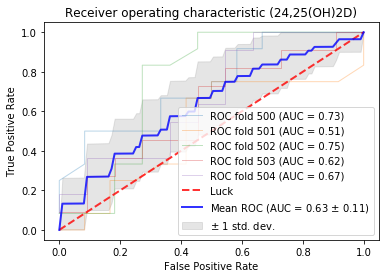

{'bootstrap': False, 'max_features': 11, 'min_samples_split': 7, 'min_samples_leaf': 1}


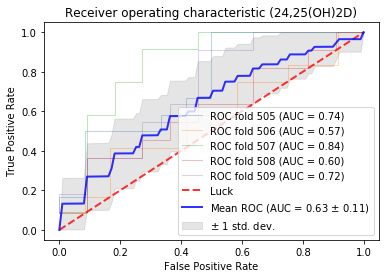

{'bootstrap': False, 'max_features': 11, 'min_samples_split': 2, 'min_samples_leaf': 3}


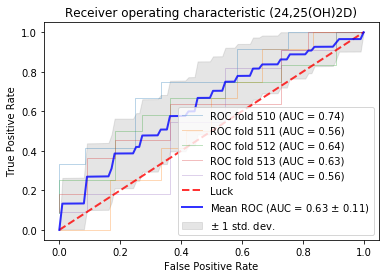

{'bootstrap': False, 'max_features': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}


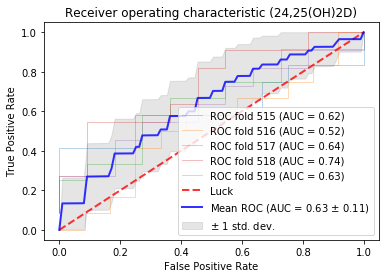

{'bootstrap': False, 'max_features': 11, 'min_samples_split': 7, 'min_samples_leaf': 3}


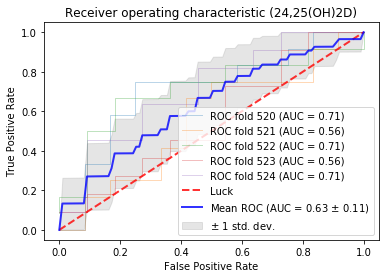

{'bootstrap': False, 'max_features': 11, 'min_samples_split': 2, 'min_samples_leaf': 7}


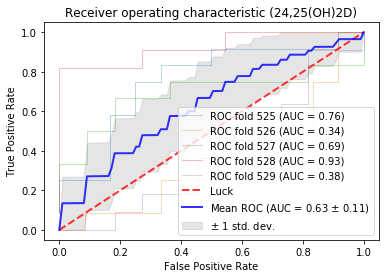

{'bootstrap': False, 'max_features': 11, 'min_samples_split': 3, 'min_samples_leaf': 7}


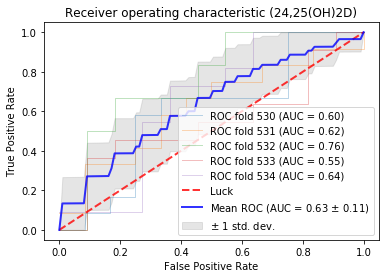

{'bootstrap': False, 'max_features': 11, 'min_samples_split': 7, 'min_samples_leaf': 7}


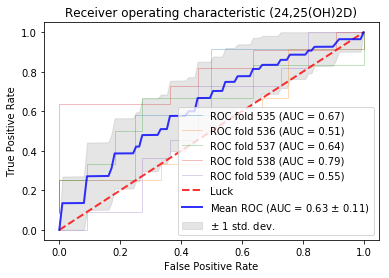

{'bootstrap': False, 'max_features': 19, 'min_samples_split': 2, 'min_samples_leaf': 1}


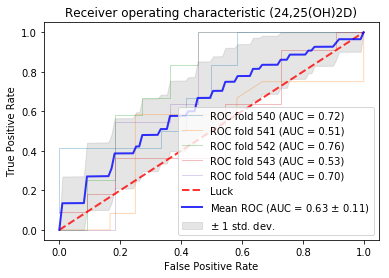

{'bootstrap': False, 'max_features': 19, 'min_samples_split': 3, 'min_samples_leaf': 1}


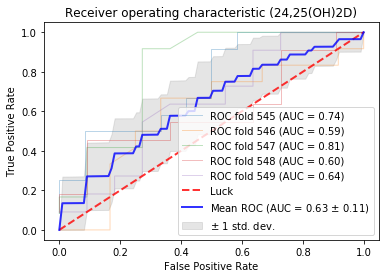

{'bootstrap': False, 'max_features': 19, 'min_samples_split': 7, 'min_samples_leaf': 1}


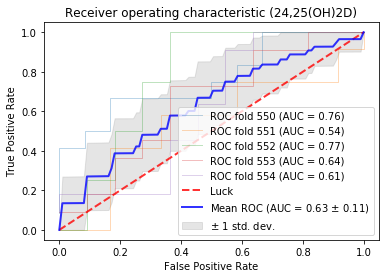

{'bootstrap': False, 'max_features': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}


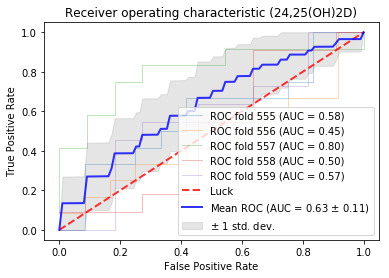

{'bootstrap': False, 'max_features': 19, 'min_samples_split': 3, 'min_samples_leaf': 3}


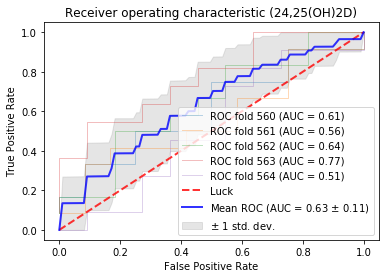

{'bootstrap': False, 'max_features': 19, 'min_samples_split': 7, 'min_samples_leaf': 3}


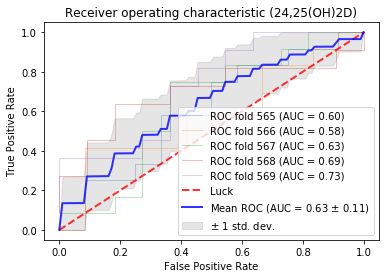

{'bootstrap': False, 'max_features': 19, 'min_samples_split': 2, 'min_samples_leaf': 7}


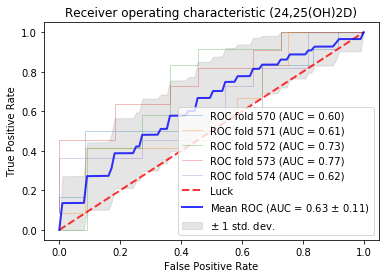

{'bootstrap': False, 'max_features': 19, 'min_samples_split': 3, 'min_samples_leaf': 7}


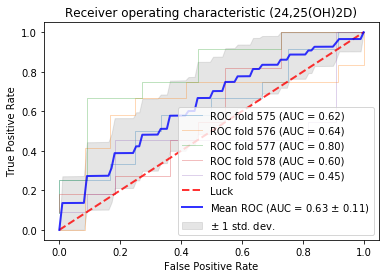

{'bootstrap': False, 'max_features': 19, 'min_samples_split': 7, 'min_samples_leaf': 7}


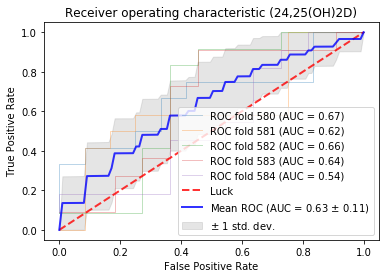

{'bootstrap': False, 'max_features': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}


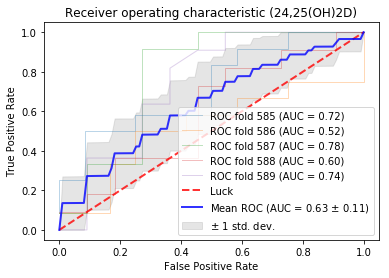

{'bootstrap': False, 'max_features': 32, 'min_samples_split': 3, 'min_samples_leaf': 1}


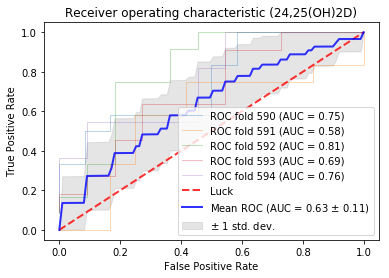

{'bootstrap': False, 'max_features': 32, 'min_samples_split': 7, 'min_samples_leaf': 1}


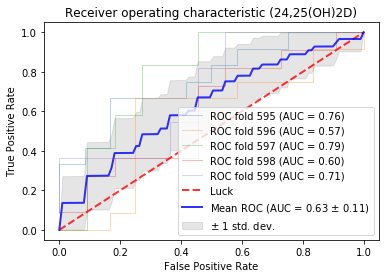

{'bootstrap': False, 'max_features': 32, 'min_samples_split': 2, 'min_samples_leaf': 3}


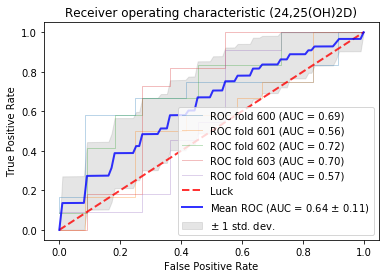

{'bootstrap': False, 'max_features': 32, 'min_samples_split': 3, 'min_samples_leaf': 3}


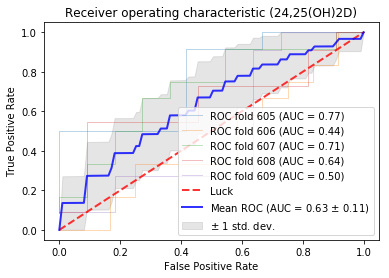

{'bootstrap': False, 'max_features': 32, 'min_samples_split': 7, 'min_samples_leaf': 3}


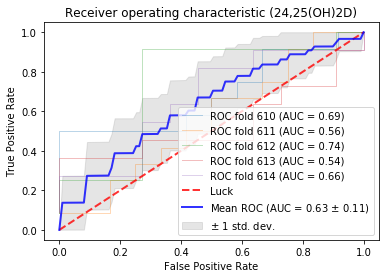

{'bootstrap': False, 'max_features': 32, 'min_samples_split': 2, 'min_samples_leaf': 7}


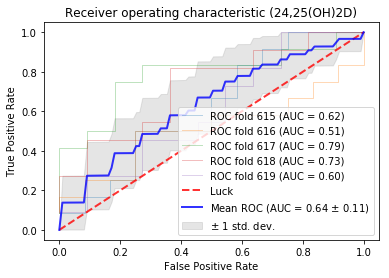

{'bootstrap': False, 'max_features': 32, 'min_samples_split': 3, 'min_samples_leaf': 7}


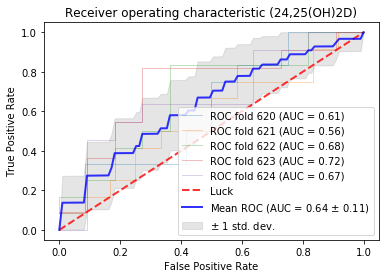

{'bootstrap': False, 'max_features': 32, 'min_samples_split': 7, 'min_samples_leaf': 7}


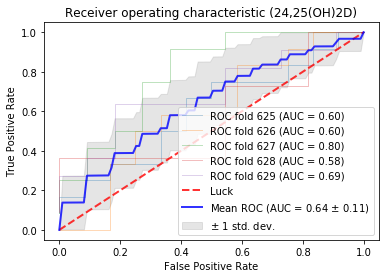

{'bootstrap': False, 'max_features': 53, 'min_samples_split': 2, 'min_samples_leaf': 1}


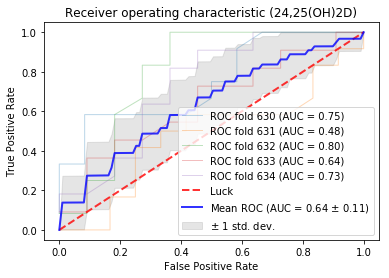

{'bootstrap': False, 'max_features': 53, 'min_samples_split': 3, 'min_samples_leaf': 1}


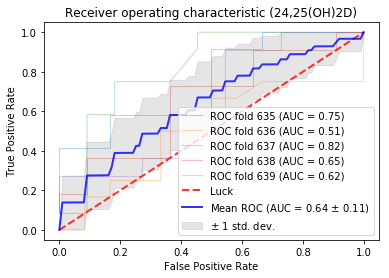

{'bootstrap': False, 'max_features': 53, 'min_samples_split': 7, 'min_samples_leaf': 1}


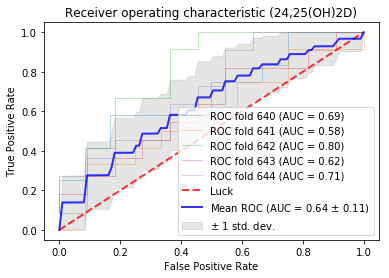

{'bootstrap': False, 'max_features': 53, 'min_samples_split': 2, 'min_samples_leaf': 3}


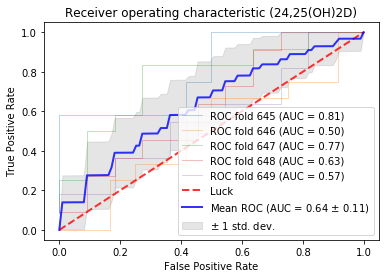

{'bootstrap': False, 'max_features': 53, 'min_samples_split': 3, 'min_samples_leaf': 3}


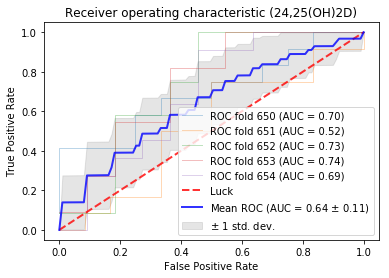

{'bootstrap': False, 'max_features': 53, 'min_samples_split': 7, 'min_samples_leaf': 3}


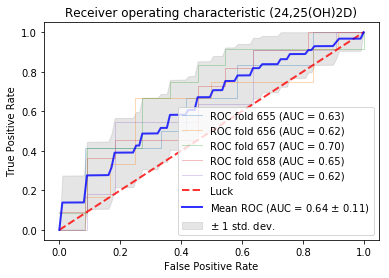

{'bootstrap': False, 'max_features': 53, 'min_samples_split': 2, 'min_samples_leaf': 7}


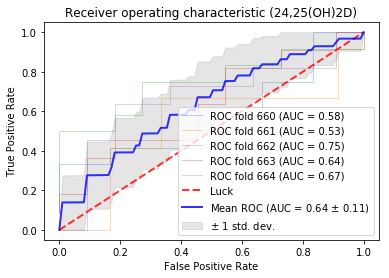

{'bootstrap': False, 'max_features': 53, 'min_samples_split': 3, 'min_samples_leaf': 7}


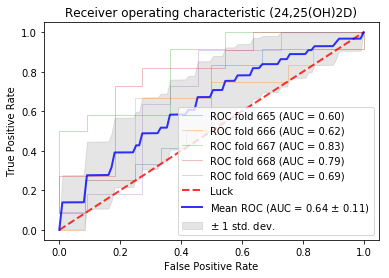

{'bootstrap': False, 'max_features': 53, 'min_samples_split': 7, 'min_samples_leaf': 7}


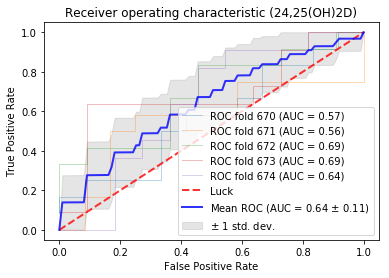

{'bootstrap': False, 'max_features': 90, 'min_samples_split': 2, 'min_samples_leaf': 1}


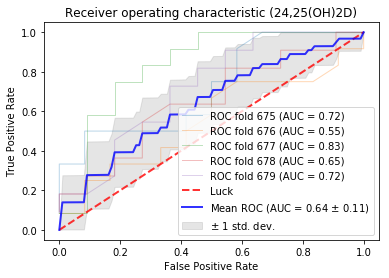

{'bootstrap': False, 'max_features': 90, 'min_samples_split': 3, 'min_samples_leaf': 1}


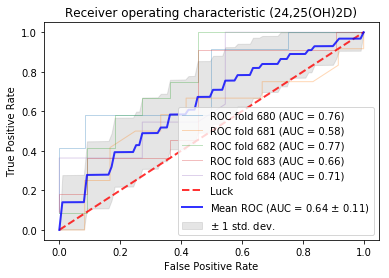

{'bootstrap': False, 'max_features': 90, 'min_samples_split': 7, 'min_samples_leaf': 1}


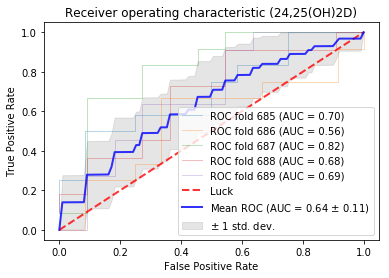

{'bootstrap': False, 'max_features': 90, 'min_samples_split': 2, 'min_samples_leaf': 3}


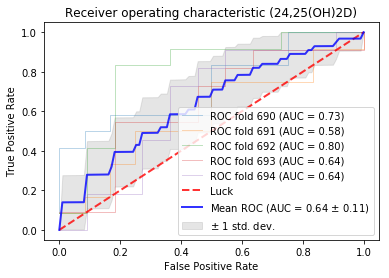

{'bootstrap': False, 'max_features': 90, 'min_samples_split': 3, 'min_samples_leaf': 3}


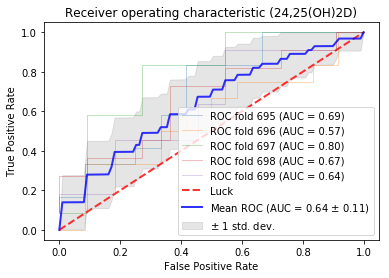

{'bootstrap': False, 'max_features': 90, 'min_samples_split': 7, 'min_samples_leaf': 3}


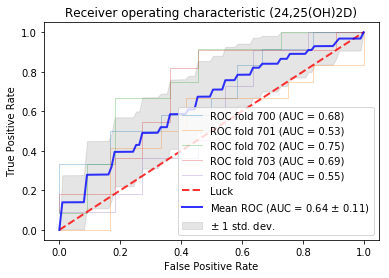

{'bootstrap': False, 'max_features': 90, 'min_samples_split': 2, 'min_samples_leaf': 7}


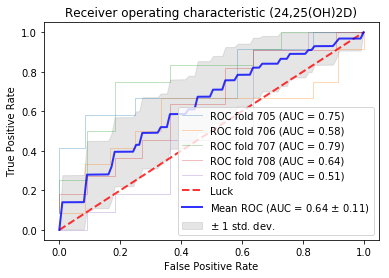

{'bootstrap': False, 'max_features': 90, 'min_samples_split': 3, 'min_samples_leaf': 7}


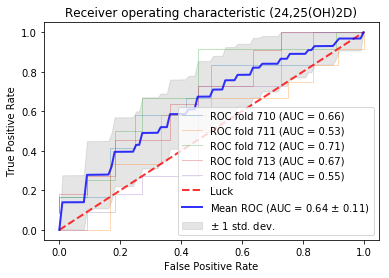

{'bootstrap': False, 'max_features': 90, 'min_samples_split': 7, 'min_samples_leaf': 7}


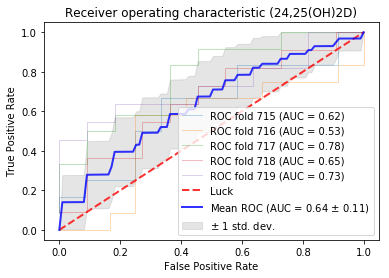

{'bootstrap': False, 'max_features': 152, 'min_samples_split': 2, 'min_samples_leaf': 1}


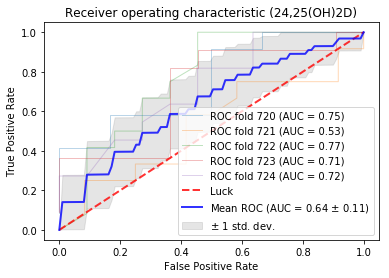

{'bootstrap': False, 'max_features': 152, 'min_samples_split': 3, 'min_samples_leaf': 1}


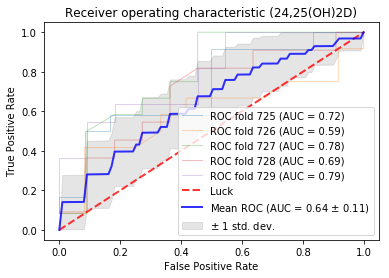

{'bootstrap': False, 'max_features': 152, 'min_samples_split': 7, 'min_samples_leaf': 1}


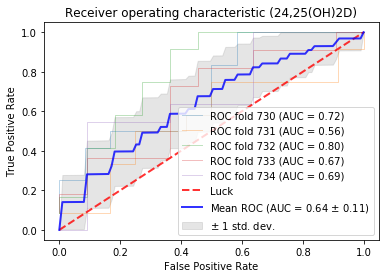

{'bootstrap': False, 'max_features': 152, 'min_samples_split': 2, 'min_samples_leaf': 3}


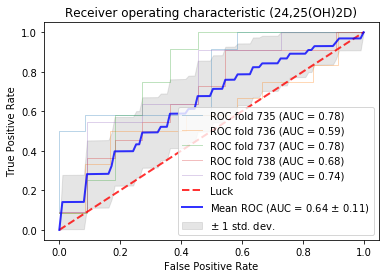

{'bootstrap': False, 'max_features': 152, 'min_samples_split': 3, 'min_samples_leaf': 3}


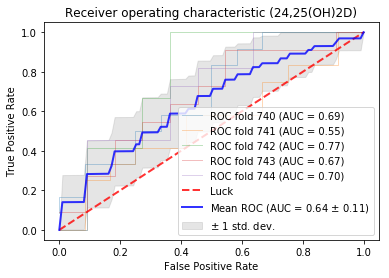

{'bootstrap': False, 'max_features': 152, 'min_samples_split': 7, 'min_samples_leaf': 3}


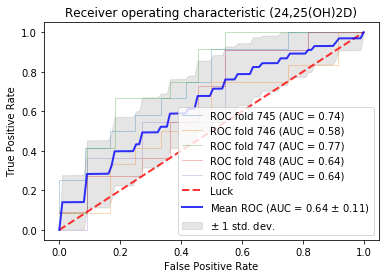

{'bootstrap': False, 'max_features': 152, 'min_samples_split': 2, 'min_samples_leaf': 7}


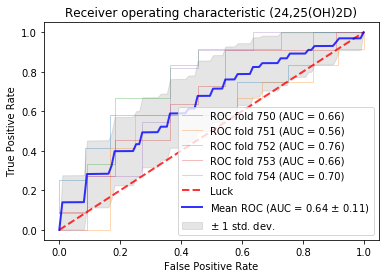

{'bootstrap': False, 'max_features': 152, 'min_samples_split': 3, 'min_samples_leaf': 7}


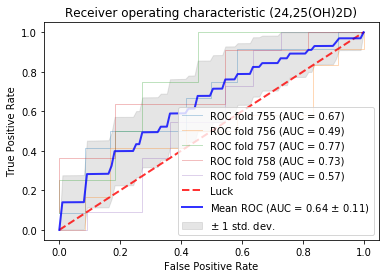

{'bootstrap': False, 'max_features': 152, 'min_samples_split': 7, 'min_samples_leaf': 7}


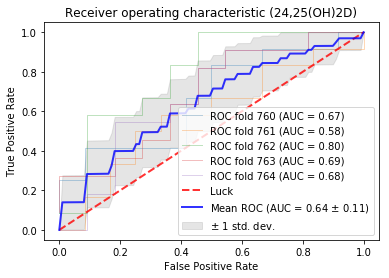

{'bootstrap': False, 'max_features': 256, 'min_samples_split': 2, 'min_samples_leaf': 1}


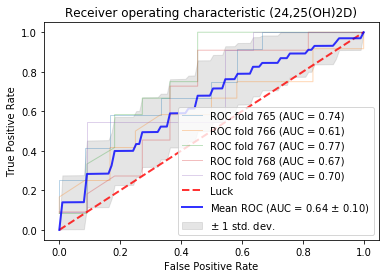

{'bootstrap': False, 'max_features': 256, 'min_samples_split': 3, 'min_samples_leaf': 1}


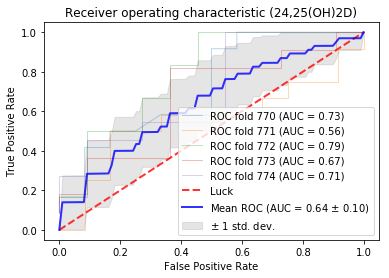

{'bootstrap': False, 'max_features': 256, 'min_samples_split': 7, 'min_samples_leaf': 1}


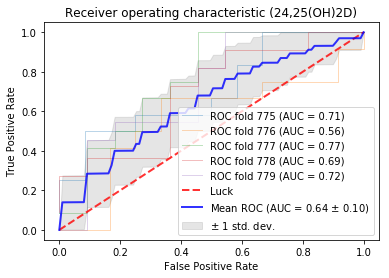

{'bootstrap': False, 'max_features': 256, 'min_samples_split': 2, 'min_samples_leaf': 3}


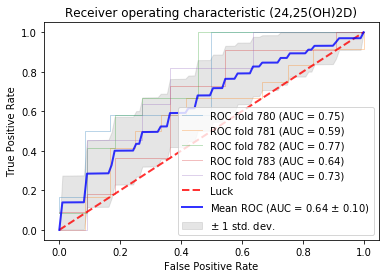

{'bootstrap': False, 'max_features': 256, 'min_samples_split': 3, 'min_samples_leaf': 3}


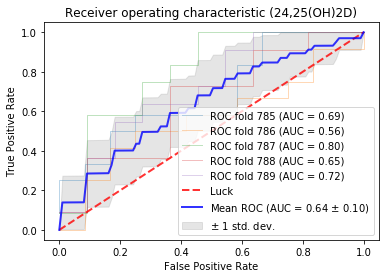

{'bootstrap': False, 'max_features': 256, 'min_samples_split': 7, 'min_samples_leaf': 3}


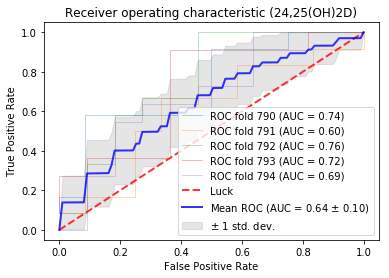

{'bootstrap': False, 'max_features': 256, 'min_samples_split': 2, 'min_samples_leaf': 7}


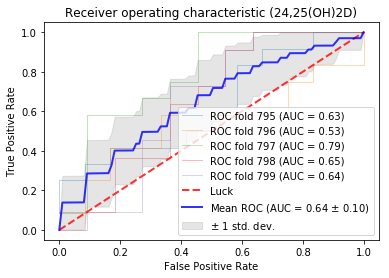

{'bootstrap': False, 'max_features': 256, 'min_samples_split': 3, 'min_samples_leaf': 7}


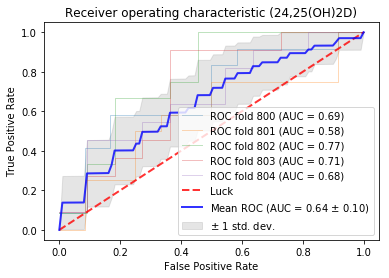

{'bootstrap': False, 'max_features': 256, 'min_samples_split': 7, 'min_samples_leaf': 7}


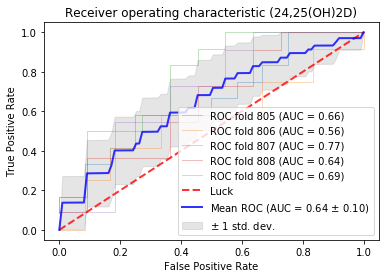

In [22]:
np.random.seed(31)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
cv = StratifiedKFold(n_splits=5)
i = 0
for params in ParameterGrid(param_grid):
    print(params)
    classifier = RandomForestClassifier(n_estimators=500, 
                                        bootstrap=params['bootstrap'], 
                                        max_features=params['max_features'],
                                        min_samples_leaf=params['min_samples_leaf'],
                                        min_samples_split=params['min_samples_split'])
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (24,25(OH)2D)')
    plt.legend(loc='lower right')
    plt.show()

In [23]:
rf_optimal = RandomForestClassifier(n_estimators=500, bootstrap=True, max_features=4,
                                    min_samples_leaf=1, min_samples_split=3)
rf_optimal.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
# highly discriminative
sum(rf_optimal.feature_importances_ >= 0.01)

0

In [25]:
# moderately discriminative
sum(rf_optimal.feature_importances_ >= 0.002)

5

In [46]:
rf_optimal.feature_importances_[rf_optimal.feature_importances_ >=0.002]
idx = np.where(rf_optimal.feature_importances_ >=0.002)
idx

(array([ 56,  67, 150, 198, 204]),)

In [47]:
A = table.loc[Y.index]
A.head()

#OTU ID    TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAAC  \
#SampleID                                                                                                                                                                                                                                                               
BI0411                                                 272.0                                                                                                                                                                                                            
BI0425                                                 359.0                                                                                                                                                                                                            
BI0444                                                   0.0                                                                                                                                                                                                            
BI0450                                                   0.0                                                                                                                                                                                                            
BI0552                                                   0.0                                                                                                                                                                                                            

#OTU ID    TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAAC  \
#SampleID                                                                                                                                                                                                                                                               
BI0411                                                   6.0                                                                                                                                                                                                            
BI0425                                                  79.0                                                                                                                                                                                                            
BI0444                                                   0.0                                                                                                                                                                                                            
BI0450                                                   0.0                                                                                                                                                                                                            
BI0552                                                   3.0                                                                                                                                                                                                            

#OTU ID    TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGATTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGAAACTGGCAGTCTTGAGTACAGTAGAGGTGGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTCACTAGACTGCAACTGACACTGATGCTCGAAAGTGTGGGTATCAAAC  \
#SampleID              

In [48]:
OTUs = A[A.columns[idx]].columns
OTUs

Index(['AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGATTGGCAAGTTGGGAGTGAAATCTATGGGCTCAACCCATAAATTGCTTTCAAAACTGTCAGTCTTGAGTGGTGTAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACTAACTGACGCTGAGGCTCGAAAGCATGGGTAGCAAAC',
       'TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGGTGGCAAGGCAAGCCAGAAGTGAAAACCCGGGGCTCAACCGCGGGATTGCTTTTGGAACTGTCATGCTAGAGTGCAGGAGGGGTGAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCGGAGGCGAAGGCGGCTCACTGGACTGTAACTGACACTGAGGCTCGAAAGCGTGGGGAGCAAAC',
       'AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAAC',
       'TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGGGAGCAGGCGGCACTAAGGGTCTGTGGTGAAAGATCGAAGCTTAACTTCGGTAAGCCATGGAAACCGTAGAGCTAGAGTGTGTGAGAGGATCGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAGGCGACGATCTGGC

In [49]:
taxa.head(3)

Taxon
Feature ID                                                                                           
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCAC...  k__Bacteria; p__Proteobacteria; c__Gammaproteo...
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...

In [50]:
B = taxa.loc[OTUs]
B.head()

Taxon
#OTU ID                                                                                              
AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGC...  k__Bacteria; p__Firmicutes; c__Clostridia; o__...
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGC...  k__Bacteria; p__Firmicutes; c__Clostridia; o__...
AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGC...  k__Bacteria; p__Firmicutes; c__Clostridia; o__...
TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGGGA...  k__Bacteria; p__Firmicutes; c__Erysipelotrichi...
TACGTAGGTGACAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGC...  k__Bacteria; p__Firmicutes; c__Clostridia; o__...

In [51]:
B['importance'] = rf_optimal.feature_importances_[idx]

In [52]:
B.shape

(5, 2)

In [53]:
B.to_csv('../data/RF_taxa_2425.txt', sep='\t')

In [54]:
B.Taxon.nunique()

4

In [55]:
B.Taxon.value_counts()

k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__; s__                               2
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__                                              1
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Faecalibacterium; s__prausnitzii    1
k__Bacteria; p__Firmicutes; c__Erysipelotrichi; o__Erysipelotrichales; f__Erysipelotrichaceae; g__; s__                 1
Name: Taxon, dtype: int64